#Imports

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_hub as hub
import tensorflow_datasets as tfds
from tensorflow.keras import layers
import logging

logger = tf.get_logger()
logger.setLevel(logging.ERROR)

#Download the Flowers Dataset with TensorFlow Datasets

The name of the dataset is `tf_flowers`. You can also see that this dataset is only split into a training set. We must use `tfds.splits` to split the dataset into a `training_set` and a `validation_set`. Do a `[70, 30]` split such that 70 corresponds to the `training_set` and 30 to the `validation_set`. Then load the `tf_flowers` dataset using `tfds.load`. Make sure the `tfds.load` function uses all the parameters you need, and also make sure it returns the dataset info, so we can retrieve information about the datasets.

In [2]:
(training_set, validation_set), info = tfds.load(
    'tf_flowers',
    with_info=True,
    as_supervised=True,
    split=['train[:70%]', 'train[70%:]']
)

#Print information about the dataset
We use the dataset info to print the number of classes in the dataset and also write some code that counts how many images we have in the training and validation sets.

In [3]:
num_training_examples = len(training_set)
num_validation_examples = len(validation_set)
num_classes = info.features['label'].num_classes

print('Total Number of Classes: {}'.format(num_classes))
print('Total Number of Training Images: {}'.format(num_training_examples))
print('Total Number of Validation Images: {} \n'.format(num_validation_examples))

Total Number of Classes: 5
Total Number of Training Images: 2569
Total Number of Validation Images: 1101 



Check if images are the same size.

In [4]:
for i, example in enumerate(training_set.take(5)):
  print('Image {} shape: {} label: {}'.format(i+1, example[0].shape, example[1]))

Image 1 shape: (333, 500, 3) label: 2
Image 2 shape: (212, 320, 3) label: 3
Image 3 shape: (240, 320, 3) label: 3
Image 4 shape: (240, 320, 3) label: 4
Image 5 shape: (317, 500, 3) label: 3


#Reformat images and create batches
We create a function that reformats all images to the resolution expected by MobileNet v2 (244 by 244) and normalizes them. The function should take in an `image` and a `label` as arguments and should return the new `image` and corresponding `label`. Then create training and validation baches of size `32`.

In [5]:
IMAGE_RES = 224

def format_image(image, label):
  image = tf.image.resize(image, (IMAGE_RES, IMAGE_RES))/255.0
  return image, label

BATCH_SIZE = 32

train_batches = training_set.shuffle(num_training_examples//4).map(format_image).batch(BATCH_SIZE).prefetch(1)
validation_batches = validation_set.map(format_image).batch(BATCH_SIZE).prefetch(1)

#Simple Transfer Learning with TensorFlow Hub
In transfer learning we reuse parts of an already trained model and change the final layer, or several layers of the model and then retrain those layers on our own dataset.

##Create feature extractor
Below we create a feature extractor using MobileNet v2. Remember that the partial model from TensorFlow Hub (without the classification layer) is called a feature vector.

In [6]:
URL = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"
feature_extractor = hub.KerasLayer(URL,
                                   input_shape=(IMAGE_RES, IMAGE_RES, 3))

##Freeze the pre-trained model
Below we freeze the variables in the feature extractor layer, so that the training only modifies the final classifier layer.

In [7]:
feature_extractor.trainable = False

##Attach a classification head
Below we create a `tf.keras.Sequential` model and add the pre-trained model as well as the new classification layer. The classification layer must have the same number of classes as our Flowers dataset. Finally we print out the summary of the Sequential model.

In [10]:
model = tf.keras.Sequential([
  feature_extractor,
  layers.Dense(num_classes, activation=tf.keras.activations.softmax)
])

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              2257984   
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 6405      
Total params: 2,264,389
Trainable params: 6,405
Non-trainable params: 2,257,984
_________________________________________________________________


##Train the model
Below we train the model like any other, first calling `compile` and then followed by `fit`. We train the model for 6 epochs.

In [11]:
EPOCHS = 6

model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

history = model.fit(train_batches,
                    epochs=EPOCHS,
                    validation_data=validation_batches
                    )

Epoch 1/6
81/81 [==============================] - 16s 94ms/step - loss: 1.0150 - accuracy: 0.6229 - val_loss: 0.4541 - val_accuracy: 0.8547
Epoch 2/6
81/81 [==============================] - 6s 76ms/step - loss: 0.3745 - accuracy: 0.8840 - val_loss: 0.3620 - val_accuracy: 0.8783
Epoch 3/6
81/81 [==============================] - 6s 76ms/step - loss: 0.2900 - accuracy: 0.9063 - val_loss: 0.3261 - val_accuracy: 0.8901
Epoch 4/6
81/81 [==============================] - 6s 76ms/step - loss: 0.2368 - accuracy: 0.9316 - val_loss: 0.3134 - val_accuracy: 0.8883
Epoch 5/6
81/81 [==============================] - 6s 76ms/step - loss: 0.2007 - accuracy: 0.9480 - val_loss: 0.3093 - val_accuracy: 0.8910
Epoch 6/6
81/81 [==============================] - 6s 76ms/step - loss: 0.1809 - accuracy: 0.9473 - val_loss: 0.2957 - val_accuracy: 0.8983


##Plot training and Validation graphs


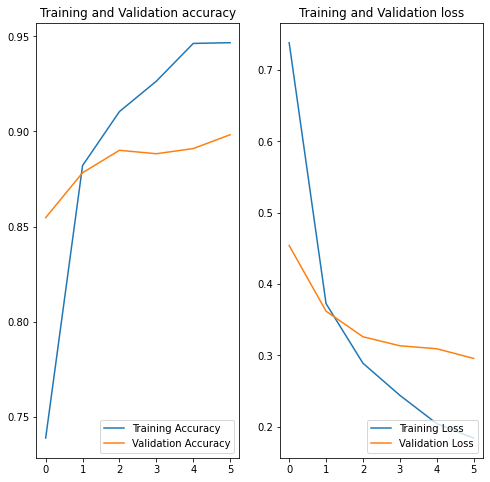

In [15]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8,8))
plt.subplot(1, 2,  1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation accuracy')

plt.subplot(1, 2,  2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='lower right')
plt.title('Training and Validation loss')
plt.show()

#Check predictions
Below we get the label names from the dataset info and convert them into a numpy array.

In [16]:
class_names = np.array(info.features['label'].names)
class_names

array(['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses'],
      dtype='<U10')

##Create an image batch and make predictions
Below, we use the `next()` function to create an `image_batch` and its corresponding `label_batch`. Convert both the `image_batch` and `label_batch` to numpy arrays using the `.numpy()` method. Then use the `.predict()` method to run the image batch through your model and make predictions. Then use the `np.argmax()` function to get the indices of the best prediction for each image. Finally we convert the indices of the best predictions to class names.

In [17]:
image_batch, label_batch = next(iter(train_batches.take(1)))

image_batch = image_batch.numpy()
label_batch = label_batch.numpy()

predicted_batch = model.predict(image_batch)
predicted_batch = tf.squeeze(predicted_batch).numpy()

predicted_ids = np.argmax(predicted_batch, axis=-1)
predicted_class_names = class_names[predicted_ids]
predicted_class_names

array(['daisy', 'daisy', 'dandelion', 'daisy', 'daisy', 'dandelion',
       'roses', 'tulips', 'daisy', 'dandelion', 'sunflowers',
       'sunflowers', 'dandelion', 'dandelion', 'tulips', 'dandelion',
       'dandelion', 'tulips', 'tulips', 'sunflowers', 'roses', 'daisy',
       'dandelion', 'tulips', 'tulips', 'dandelion', 'tulips',
       'sunflowers', 'daisy', 'tulips', 'daisy', 'roses'], dtype='<U10')

##Print true labels and predicted indices
Below we print the true labels and the indices of predicted labels.

In [19]:
print('True labels: ', label_batch)
print('Predicted labels: ', predicted_ids)

True labels:  tf.Tensor([1 1 0 1 1 0 4 2 1 0 3 3 0 0 2 0 0 2 2 3 4 1 0 2 2 0 2 3 1 2 1 4], shape=(32,), dtype=int64)
Predicted labels:  [1 1 0 1 1 0 4 2 1 0 3 3 0 0 2 0 0 2 2 3 4 1 0 2 2 0 2 3 1 2 1 4]


#Plot model predictions

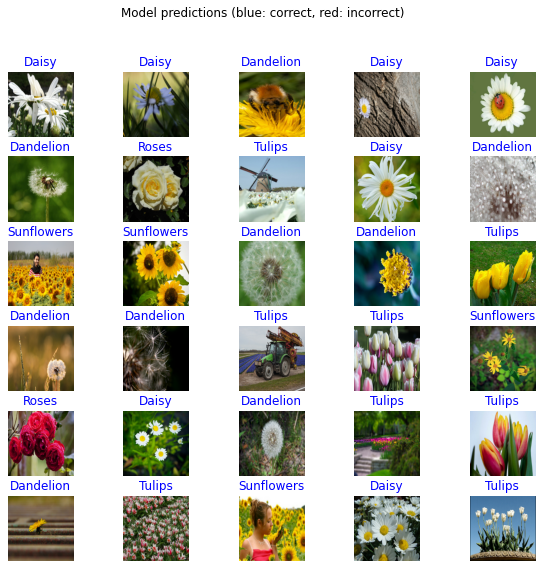

In [20]:
plt.figure(figsize=(10,9))
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.subplots_adjust(hspace=0.3)
  plt.imshow(image_batch[n])
  color = 'blue' if predicted_ids[n] == label_batch[n] else 'red'
  plt.title(predicted_class_names[n].title(), color=color)
  plt.axis('off')
_ = plt.suptitle('Model predictions (blue: correct, red: incorrect)')